# TIMIT Benchmark

In this section, we benchmark the perofrmance of different handcrafted and data-driven features against a speaker recognition task using TIMIT dataset.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import deciphering_enigma
import matplotlib.pyplot as plt
from collections import defaultdict
from deciphering_enigma.settings import _MODELS_WEIGHTS, palette

In [2]:
import matplotlib
from pylab import cm
import matplotlib as mpl
matplotlib.font_manager._fmcache
matplotlib.font_manager._rebuild()
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 3

2022-11-02 19:22:44 | INFO | matplotlib.font_manager | Generating new fontManager, this may take some time...


## Dataset:
[TIMIT](https://catalog.ldc.upenn.edu/LDC93s1) is a read speech corpus that comprises 630 speakers uttering ten phonetically rich sentences with total of 6300 utterances. The dataset has speakers of eight different dialects of American English. We used this corpus as a speaker recognition downstream task. We extracted all handcrafted and data-driven features from this dataset and benchmarked the models' performances. We trained a classifier on seven randomly-selected scentences per speaker and kept three scentences for testing.

## Evaluation Details:
The evaluation pipeline includes extracting the features of TIMIT utterances from each model (handcrfated or self-supervised). The features of each utterance is temporally pooled using *mean+max* to generate 1D vector per sample. Then, we trained a single linear layer classifier to fit the features from the train set of TIMIT using adam optimizer with early stopping after patience of 10 epochs. The classifier trains for 200 epochs with learning being tuned to optimize the results between 0.0001 to 0.01, we manually checked lower learning rate values that yielded worst results. Also we tuned the number of nodes in the linear layer with values 10, 50 and 100 nodes. The features were standardized before training the linear classifier. We ran this process ten times for each model and reported the *unweighted average recall* (UAR) percentage. We used *scikit-learn* package to benchmark the downstream task.

## Evaluation Results:

### 1) TIMIT Benchmark

In the Figure below, we reported the average UAR percentage for each model with 95% confidence interval.

In [16]:
from glob import glob
files = glob('/om2/user/gelbanna/timit_benchmark/*/*results.csv')
files += glob('/om2/user/gelbanna/voxceleb_1/*/*finallayer.csv')
files = [file for file in files if 'encoder' not in file and 'conv' not in file and 'bootstrap' not in file]
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs)
df['Score'] *= 100

In [18]:
df.drop(columns='Unnamed: 0', inplace=True)

In [20]:
df = pd.read_csv('/om2/user/gelbanna/timit_benchmark/benchmark_scores.csv')

In [19]:
df.to_csv('/om2/user/gelbanna/timit_benchmark/benchmark_scores.csv')

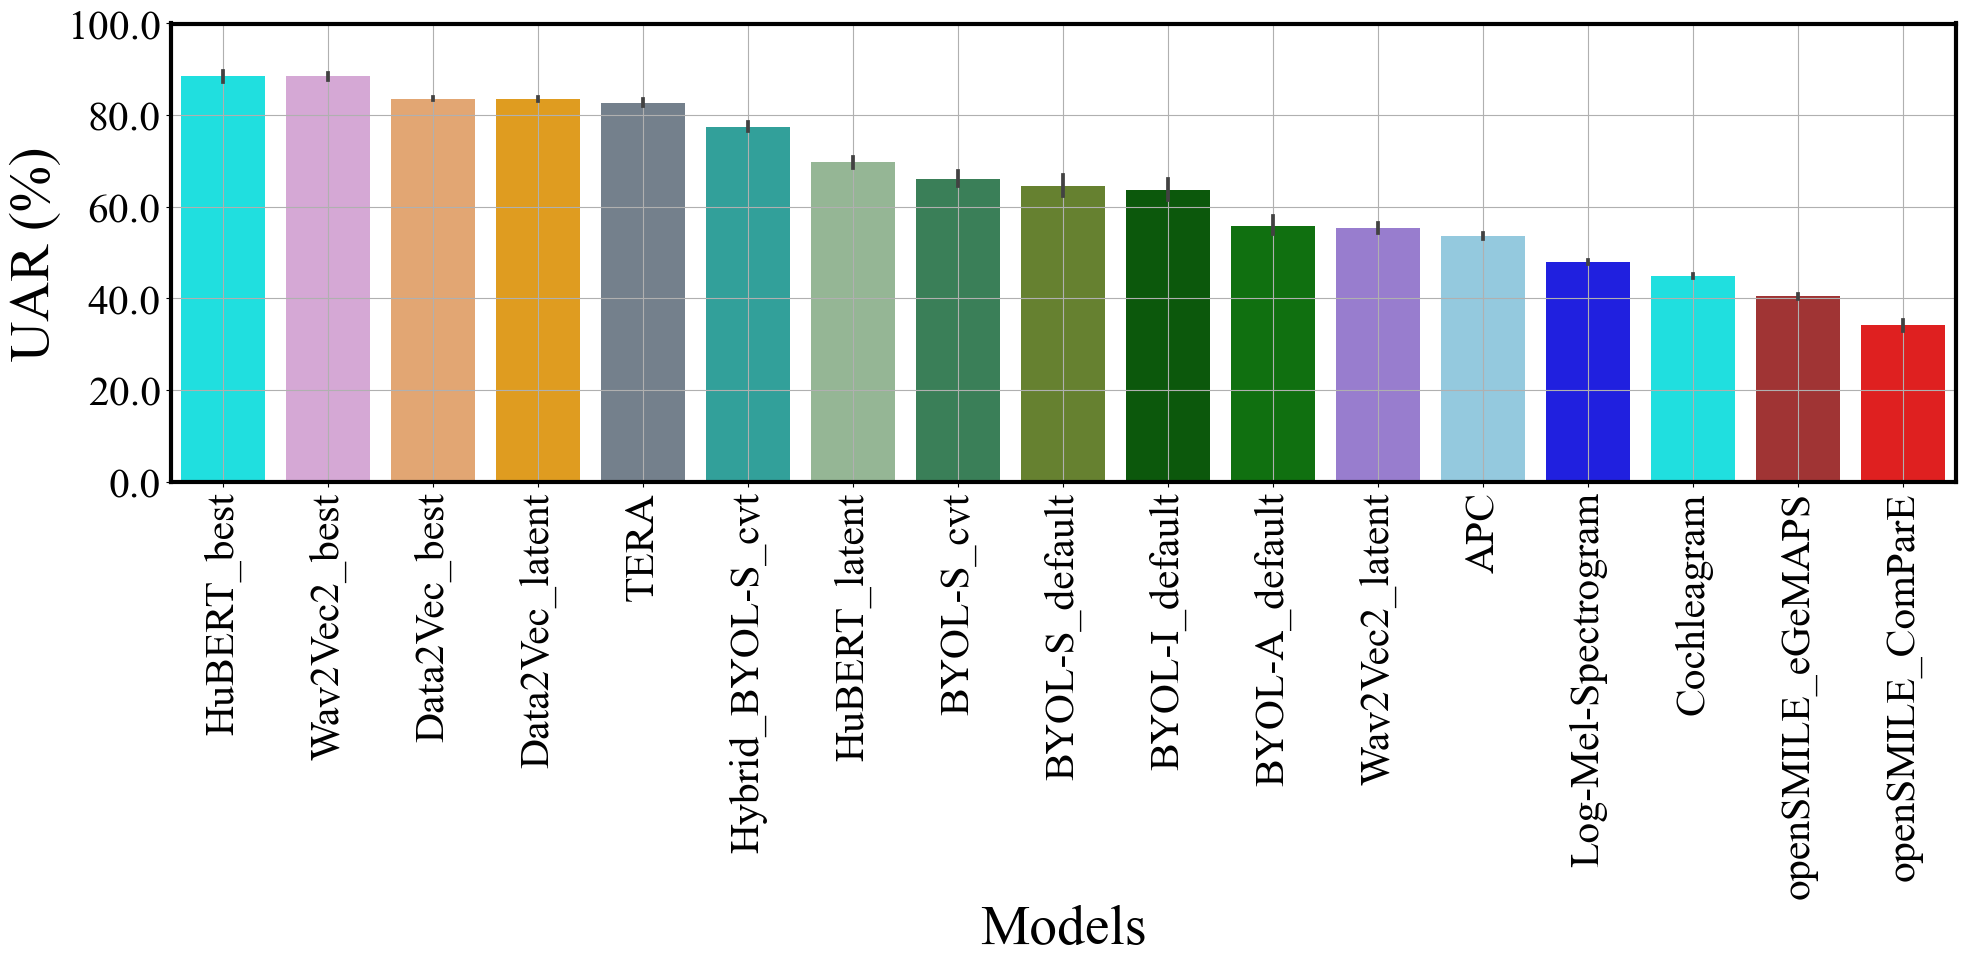

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
order = list(df.groupby('Model')['Score'].mean().sort_values(ascending = False).index)
sns.barplot(data=df, x='Model', y='Score', ax=ax, order=order, palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), size=30, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size=30)
ax.set_ylabel('UAR (%)', fontsize=40)
ax.set_xlabel('Models', fontsize=40)
ax.set_ylim([0, 100])
plt.grid()
plt.tight_layout()

### 2) Layer-wise Analysis

To thoroughly examine a model's performance, evaluating the intermediate representations across layers might elucidate the model's best layer for a downstream task. Moreover, the three models (Wav2Vec2, HuBERT and Data2Vec) share similar architectural structures comprising layers of CNN followed by layers of transformers. Thus, as shown in Figure below, we also benchmarked the performance of the latent features generated from the last CNN layer in these models and the contextual features generated from the last transformer layer which happens to be the features examined in the Figure above. Additionally, we reported the performance of the best layer for Wav2Vec2 and HuBERT which happens to be transformer 1st and 7th layers respectively. While for Data2Vec we found that the best performing layer is the last convolutional layer which generates latent representations.

![latent_contextual_figure.png](latent_contextual_figure.png)

In [74]:
df = pd.read_csv('/om2/user/gelbanna/timit_benchmark/layerwise_analysis.csv')

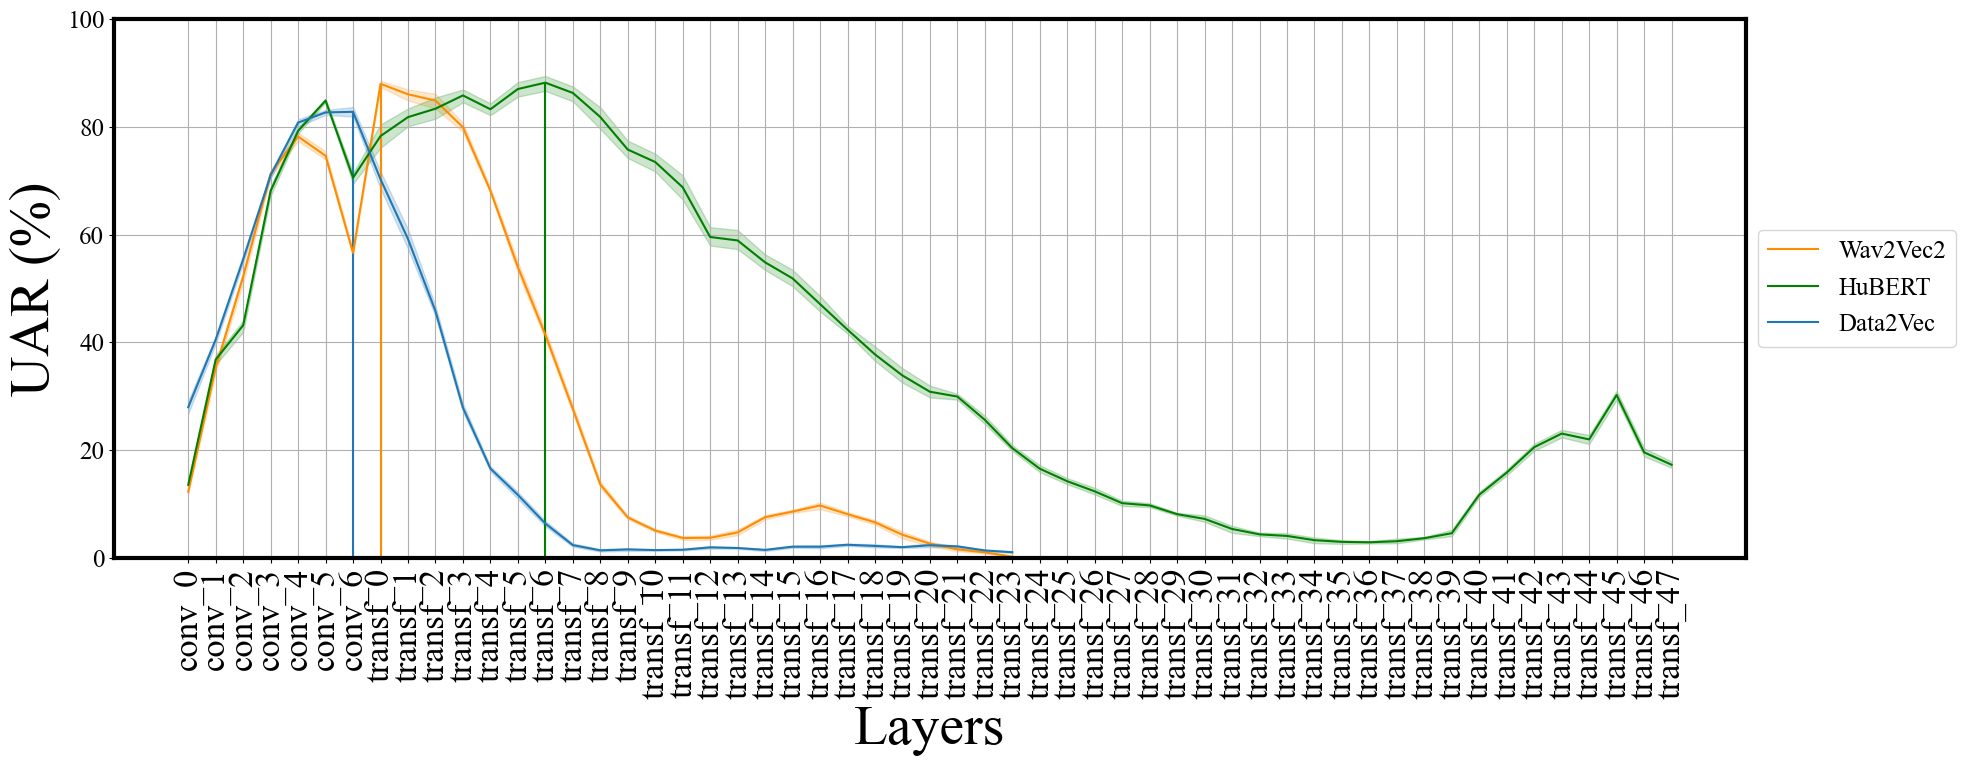

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
palette = {'Wav2Vec2':'darkorange', 'HuBERT': 'green', 'Data2Vec': '#1f77b4'}
line = sns.lineplot(data=df, x='Layer', y='Score', hue='Model', ax=ax, palette=palette)
ax.set_xticks(df.Layer.unique())
ax.set_xticklabels(df.Layer.unique(), rotation=90, fontsize=25)
ax.vlines(6, ymin=0, ymax=df['Score'].loc[(df.Model=='Data2Vec')&(df.Layer=='conv_6')].mean())
ax.vlines(13, ymin=0, ymax=df['Score'].loc[(df.Model=='HuBERT')&(df.Layer=='transf_6')].mean(), color='green')
ax.vlines(7, ymin=0, ymax=df['Score'].loc[(df.Model=='Wav2Vec2')&(df.Layer=='transf_0')].mean(), color='darkorange')
ax.set_ylabel('UAR (%)', fontsize=40)
ax.set_ylim([0,100])
ax.set_xlabel('Layers', fontsize=40)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid()

In [23]:
df = pd.read_csv('/om2/user/gelbanna/timit_benchmark/facebook_models.csv')

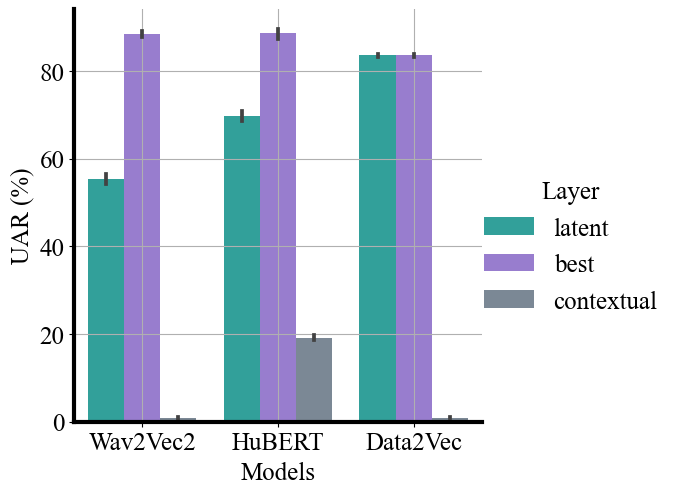

In [24]:
order=['Wav2Vec2', 'HuBERT', 'Data2Vec']
hue_order = ['latent', 'best', 'contextual']
palette = {'latent': 'lightseagreen', 'best':'mediumpurple', 'contextual':'lightslategrey'}
g = sns.catplot(data=df, kind="bar", x="Model", y="Score", hue="Layer", order=order, hue_order=hue_order, palette=palette)
g.set_axis_labels("Models", "UAR (%)")
plt.grid()

### 3) Centered Kernel Alignment (CKA)

Additionally, we further measured the representation similaritites across all models. The method used as a proxy for embeddings similaritiy is **Centered Kernel Alignment** (CKA). It is a dot product-based method used to study similarities across representations generated by deep neural networks. CKA computes similarity by normalizing **Hilbert-Schmidt Independence Criterion** (HSIC) to be invariant to isotropic scaling, as shown below.

![](cka_formula.png)

In [3]:
#define the experiment config file path
path_to_config = './config.yaml'

#read the experiment config file
exp_config = deciphering_enigma.load_yaml_config(path_to_config)
dataset_path = exp_config.dataset_path

#register experiment directory and read wav files' paths
audio_files = deciphering_enigma.build_experiment(exp_config)
audio_files = [audio for audio in audio_files if audio.endswith('_normloud.wav')]
print(f'Dataset has {len(audio_files)} samples')

#extract metadata from file name convention
metadata_df, audio_format = deciphering_enigma.extract_metadata(exp_config, audio_files)
metadata_df['AudioPath'] = audio_files
metadata_df['ID'] = np.array(list(map(lambda x: x.split('/')[-2][1:], audio_files)))
metadata_df['Gender'] = np.array(list(map(lambda x: x.split('/')[-2][0], audio_files)))

#load audio files as torch tensors to get ready for feature extraction
audio_tensor_list = deciphering_enigma.load_dataset(audio_files, cfg=exp_config, speaker_ids=metadata_df['ID'], audio_format=audio_format)
#generate speech embeddings
feature_extractor = deciphering_enigma.FeatureExtractor()
embeddings_dict = feature_extractor.extract(audio_tensor_list, exp_config)

Dataset has 6300 samples
Audio Tensors are already saved for timit_benchmark
Load Log-Mel-Spectrogram Model
Log-Mel-Spectrogram embeddings are already saved for timit_benchmark
(6300, 128)
Load Cochleagram Model
Cochleagram embeddings are already saved for timit_benchmark
(6300, 85)
Load openSMILE_eGeMAPS Model
openSMILE_eGeMAPS embeddings are already saved for timit_benchmark
(6300, 88)
Load openSMILE_ComParE Model
openSMILE_ComParE embeddings are already saved for timit_benchmark
(6300, 6373)
Load BYOL-A_default Model
BYOL-A_default embeddings are already saved for timit_benchmark
(6300, 2048)
Load BYOL-S_default Model
BYOL-S_default embeddings are already saved for timit_benchmark
(6300, 2048)
Load BYOL-I_default Model
BYOL-I_default embeddings are already saved for timit_benchmark
(6300, 2048)
Load BYOL-S_cvt Model
BYOL-S_cvt embeddings are already saved for timit_benchmark
(6300, 2048)
Load Hybrid_BYOL-S_cvt Model
Hybrid_BYOL-S_cvt embeddings are already saved for timit_benchmark


CKA is already saved


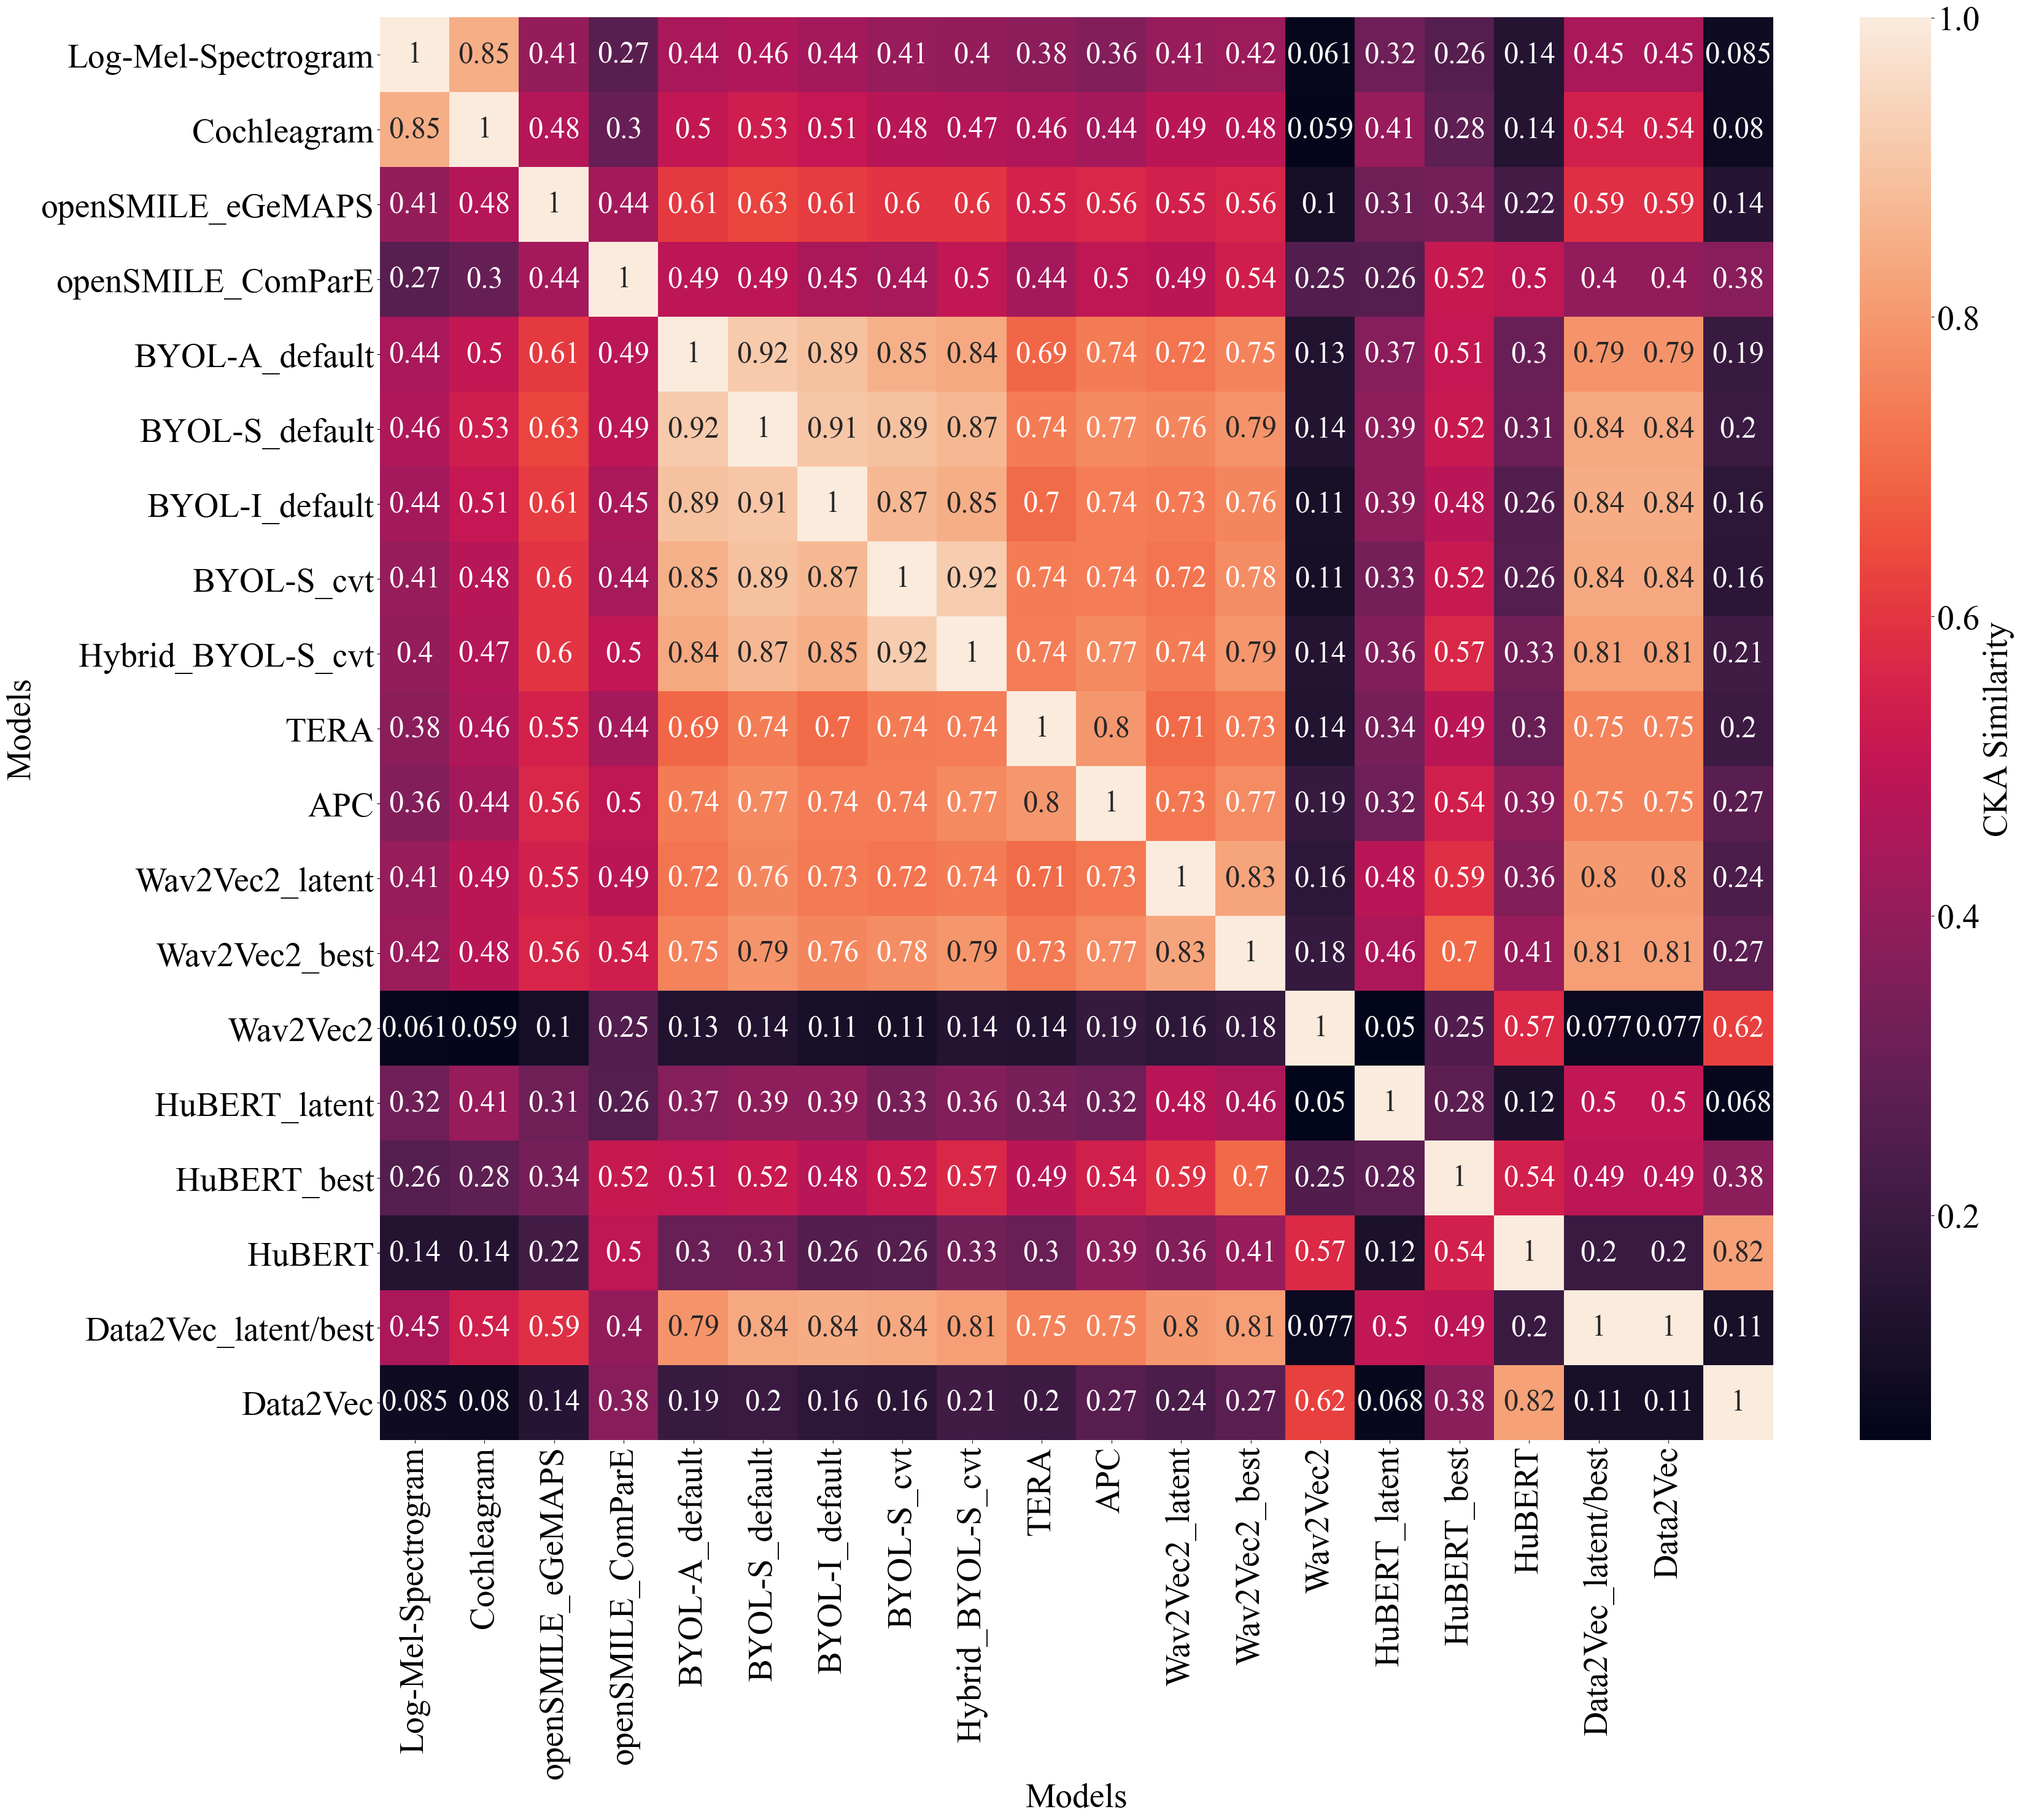

In [17]:
cka_class = deciphering_enigma.CKA(unbiased=True, kernel='rbf', rbf_threshold=0.5)
cka_ = cka_class.run_cka(embeddings_dict, save_path=f'../{exp_config.dataset_name}/', save_array=True)
cka_class = cka_class.plot_heatmap(cka_, embeddings_dict.keys(), save_path=f'../{exp_config.dataset_name}', save_fig=True)

## Discussion:

In this section, we have benchmarked the performance of several handcrafted and data-driven models on a speaker recognition task using TIMIT dataset. We have observed that the best-performing models on TIMIT and VoxCeleb datasets are **TERA** and **Hybrid BYOL-S**. Additionally for TIMIT task the last convolutional layer in **Data2Vec** is yielding the best performance. Surprisingly, we noticed that the state-of-the-art self-supervised models such as *HuBERT*, *Wav2Vec 2.0* and *Data2Vec* have featured significantly low predictive power compared to DSP-based features (openSMILE) and spectrograms. Accordingly, we applied layerwise analysis to further elucidate the performance across all layers in the aforementioned models. That said, it was observed that earlier layers have shown higher performance compared to final ones, suggesting that these models maximized speaker-related information coding in earlier layers. In retrospect, one can argue that this behavior is quite intuitive given the training pretext task these models optimized. These models were mainly trained to predict hidden/masked speech units making the model focus on prioritizing language and phonetic information above speaker-related information. Hence, the degraded performance as we move to final layers. It is worth mentioning that the best-performing layers for three models outperformed the top models for this task as shown in the first figure. Lastly, we computed a similarity metric (CKA) across different representations. As shown in the figure above, the final layer representations from HuBERT, Wav2Vec 2.0 and Data2Vec showed the lowest CKA scores with the rest of the models indicating that these representations might encode different information compared to other models. However, they share high CKA scores between each other.